## ***CE-672 Assignment - 03***
### **Amipriya Anand (220122)**

In [2]:
# import necessary libraries
import rasterio
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog, ttk
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import itertools

#### Function to determine the OIF and Sheffield index

C:\Users\amipr\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


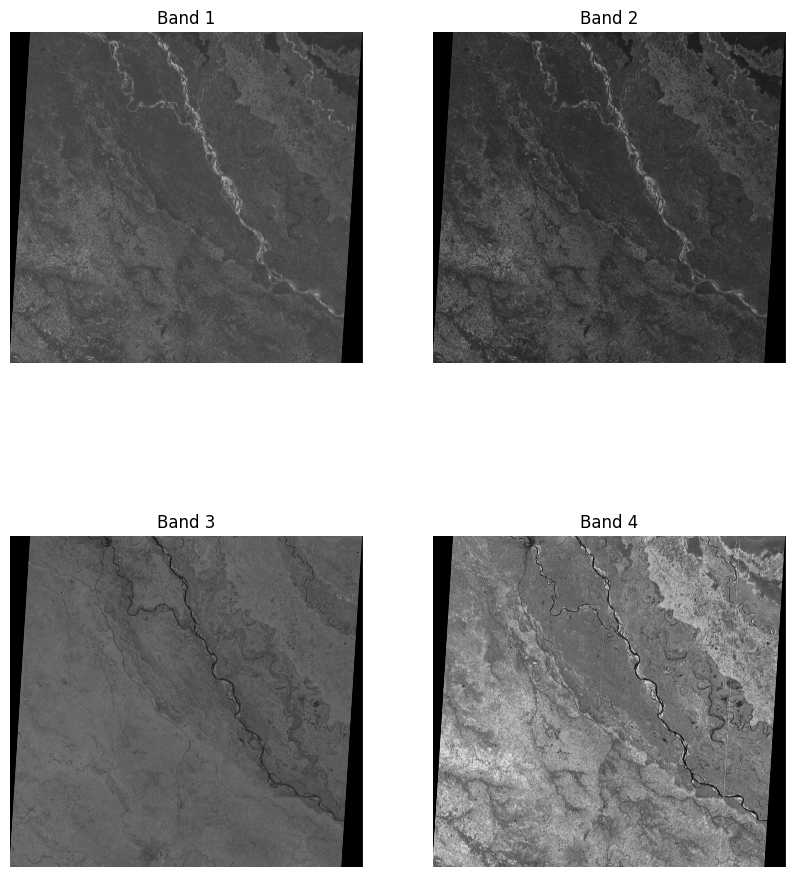

In [3]:
# code just to display the image in all bands in 8 bit fcc of gray
# please ensure that this imagery file is saved at the same location where this file is saved

with rasterio.open("IMAGERY.L-3") as img:
    bands = [img.read(i + 1).astype(np.float32) for i in range(img.count)]

plt.figure(figsize=(10, 12))

# Plot each band separately
for i in range(img.count):
    plt.subplot(2, 2, i + 1)
    plt.imshow(bands[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Band {i+1}")

plt.show()

In [4]:
# function to determine OIF 
def determine_OIF(bands, band_comb_idx):
    """
    determines the OIF by takin input as all the bands and the combination of the indicies
    """
    bands_selected = [bands[i] for i in band_comb_idx]
    
    # standard deviation of each of the bands
    band_std_array = [np.std(band) for band in bands_selected]
    
    # compute sigma
    sigma = np.sum(band_std_array)
    
    # computing the correlation coefficitient matrix 
    corr_coef_matrix = np.corrcoef([band.flatten() for band in bands_selected])
    
    # compute sum of absolute values of r
    abs_r = np.sum(np.abs(corr_coef_matrix[np.triu_indices(len(band_comb_idx),k=1)]))

    # return OIF asper formula simga/abs_r
    return sigma/abs_r if abs_r != 0 else 0


In [5]:
# function to determine Sheffield Index
def determine_Sheffield_Index(bands, band_comb_idx):
    """
    determines the Sheffield Index by takin input as all the bands and the combination of the indicies
    """
    bands_selected = [bands[i] for i in band_comb_idx]
    
    # standard deviation of each of the bands
    band_std_array = [np.std(band) for band in bands_selected]
    
    # compute sigma
    sigma = np.sum(band_std_array)
    
    # computing the correlation coefficitient matrix 
    corr_coef_matrix = np.corrcoef([band.flatten() for band in bands_selected])
    
    # compute sum of absolute values of r
    abs_r = np.sum(np.abs(corr_coef_matrix[np.triu_indices(len(band_comb_idx),k=1)]))

    # return OIF asper formula simga/abs_r
    return sigma/(abs_r+1) 


In [6]:
# determine best band combinationaccording to OIF or Sheffield index
def best_band_comb(bands,method = 0):
    """
    determines the best band combination according to the method input
    returns tuple containing best combination and best score by that method
    method can be "OIF" [0] and "SI" (Sheffield Index) [1]
    """ 
    indicies_comb = list(itertools.combinations(range(len(bands)),3))
    best_comb_indices = None
    best_score = float('-inf')

    # for OIF method
    if method == 0:
        for combo in indicies_comb:
            score = determine_OIF(bands,combo)
            if best_score < score:
                best_score = score
                best_comb_indices = combo
        return best_comb_indices, best_score
    
    # for SI method
    elif method == 1:
        for combo in indicies_comb:
            score = determine_Sheffield_Index(bands,combo)
            if best_score < score:
                best_score = score
                best_comb_indices = combo
        return best_comb_indices, best_score
    
    return best_comb_indices,best_score

In [7]:
# result for the method 1 : Sheffield Index
tup = best_band_comb(bands,1)
print("best band Combination: ",tup[0],"\nbest score: ",tup[1])

best band Combination:  (1, 2, 3) 
best score:  28.400813846891836


##### **Creating GUI**

##### Functions for the GUI


In [8]:
# this will open dialog box to select the file in the gui
# for taking the image file as input
def select_file():
    """
    Opens a file dialog to select the Image file and assign the list of values to the colour gun
    """
    global available_bands
    global selected_file
    selected_file = filedialog.askopenfilename(title="Select Image File")
    if selected_file:
        messagebox.showinfo("File Selected", f"Selected: {selected_file}")
        
        # once the image is selected, configure the dropdown menu based on the number of bands 
        with rasterio.open(selected_file) as img:
            available_bands = [str(i+1) for i in range(img.count)]
            
            # set the band values 
            r_band.set(available_bands[0])
            g_band.set( available_bands[0])
            b_band.set( available_bands[0])
            # set dropdown values
            r_dropdown["values"] = available_bands
            g_dropdown["values"] = available_bands
            b_dropdown["values"] = available_bands

            

In [9]:
# function to display the original image in a new window
def display_image():
    """
    Function displays the original image 
    """
    if not selected_file:
        messagebox.showerror("Error", "Please Select an Image file")
    else:
        # Open the raster image
        with rasterio.open(selected_file) as img:
            bands = img.count  # Number of bands in the image

            # If it's a grayscale image, read the first band
            if bands == 1:
                image_array = img.read(1).astype(np.uint8)
            else:
                # Read first 3 bands for an RGB representation
                image_array = np.stack([img.read(i + 1) for i in range(min(3, bands))], axis=-1).astype(np.uint8)

    # Convert to PIL Image
    img_pil = Image.fromarray(image_array)

    # Open a new Tkinter window for displaying the image
    new_window = tk.Toplevel(root)
    new_window.title("Original Image")
    img_pil = img_pil.resize((500, 500))  # Resize for better display
    img_tk = ImageTk.PhotoImage(img_pil)

    label = tk.Label(new_window, image=img_tk)
    label.image = img_tk  # Keep reference to avoid garbage collection
    label.pack()

        

In [10]:
# function to store the colour guns 
def store_color_gun():
    """
    Assigns colour Gun based on user preference
    """
    global color_gun_assignment
    try:
        # as per 1 based indexing of colour gun
        color_gun_assignment = (int(r_band.get()), int(g_band.get()), int(b_band.get()))
        messagebox.showinfo("Success", f"Color Gun Assigned: {color_gun_assignment}")
    except ValueError:
        messagebox.showerror("Error", "Please select valid band numbers!")


In [11]:
# functtion to normalise band input to 8 bit depth
def normalise_band(band):
    """
    Normalises each band input values ranging from 0 to 255 (integer)
    """
    return (((band-band.min())/(band.max()-band.min()))*255).astype(np.uint8)

In [12]:
# function to display the FCC image 
def display_fcc_image():
    """
    Displays the chosen image using the colour gun and the fcc assigned to it.
    """
    if not selected_file:
        messagebox.showerror("Error","Please select image file")
        return
    if not color_gun_assignment:
        messagebox.showerror("Error", "Please Assign the Colour Gun values")
        return
    
    with rasterio.open(selected_file) as img:
        bands = [img.read(i + 1).astype(np.float32) for i in range(img.count)]

    # as per 0 based indexing
    red_band = bands[color_gun_assignment[0]-1]
    green_band = bands[color_gun_assignment[1]-1]
    blue_band = bands[color_gun_assignment[2]-1]

    # normalise each RGB band
    r_norm = normalise_band(red_band)
    g_norm = normalise_band(green_band)
    b_norm = normalise_band(blue_band)
    
    # get fcc value generate fcc image
    fcc = fcc_type.get()
    if fcc == "24-bit":
        fcc_image = np.dstack((r_norm,g_norm,b_norm))
    else:
        fcc_image = r_norm
    
    # display it in seperate window
    # Convert NumPy array to PIL Image
    global fcc_img_pil
    fcc_img_pil = Image.fromarray(fcc_image)

    # Open a new Tkinter window for displaying the image
    new_window = tk.Toplevel(root)
    new_window.title(f"{fcc} False Color Composite")
    
    fcc_img_pil = fcc_img_pil.resize((500, 500))                        # Resize for better display
    img_tk = ImageTk.PhotoImage(fcc_img_pil)

    label = tk.Label(new_window, image=img_tk)
    label.image = img_tk                                        # Keep reference to avoid garbage collection
    label.pack()

In [13]:
# Function to save the FCC image
def save_fcc_image():
    """
    Function to save the FCC image
    """
    global fcc_img_pil
    if fcc_img_pil is None:
        messagebox.showerror("Error", "No image to save!")
        return

    save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Files", "*.png"), ("JPEG Files", "*.jpg"), ("TIFF Files", "*.tiff")])
    if save_path:
        fcc_img_pil.save(save_path)
        messagebox.showinfo("Success", f"Image saved as {save_path}")

In [14]:
# function to display meta data 
def display_meta_data():
    """
    Displays Meta data
    """
    if not selected_file:
        messagebox.showerror("Error", "Please select an image file first.")
        return
    meta_info = rasterio.open(selected_file).meta
    meta_text = "\n".join([f"{key}:\t{value}" for key,value in meta_info.items()])
    messagebox.showinfo("Meta data", meta_text)


In [15]:
# function to display best combination
def display_best_comb():
    """
    Displays OIF and SI best conbination band
    """
    if not selected_file:
        messagebox.showerror("Error", "Please select an image file first.")
        return
    with rasterio.open(selected_file) as img:
            bands = [img.read(i + 1).astype(np.float32) for i in range(img.count)]
            OIF_data = best_band_comb(bands, 0)
            SI_data = best_band_comb(bands, 1)
            
    text = f"Best band Combination as per OIF: {np.array(OIF_data[0])+1}\nBest OIF: {OIF_data[1]}\nBest band Combination as per SI: {np.array(SI_data[0])+1}\nBest SI: {SI_data[1]}"
    messagebox.showinfo("Best Band Combination data", text)

##### Creating the button layout in our GUI


In [ ]:
# Create the main GUI window
root = tk.Tk()
root.title("My(220122) FCC Image Viewer")
root.geometry("708x500")

# declare global variables of GUI
# for storing the number of bands in the selected image
available_bands = []
selected_file = None                                # this will be the file path used in the GUI globally
color_gun_assignment = None                         # this will assign colour gun to the image 
fcc_type = tk.StringVar(value="24-bit")             # Default FCC type
fcc_img_pil = None                                  # to store fcc image
# for colour gun assignment 
r_band = tk.StringVar()
g_band = tk.StringVar()
b_band = tk.StringVar()

tk.Label(root, text="------ Select the Image file ------",font=("Times New Roman",12,"bold")).pack()


# creating the button layout 
button_frame = tk.Frame(root,highlightbackground="black" ,highlightthickness=1)
button_frame.pack(pady=10, padx=10)

tk.Button(button_frame, text="Select Image File", command=select_file).grid(row= 0, column=0, padx= 10, pady = 10)
tk.Button(button_frame, text="Display Original Image", command=display_image).grid(row= 0, column=1, padx= 10, pady= 10)
tk.Button(button_frame, text="Display Meta Data", command=display_meta_data).grid(row= 1, column=0, padx= 10, pady= 10)
tk.Button(button_frame, text="Display Best Combination", command=display_best_comb).grid(row= 1, column=1, padx= 10, pady= 10)

# Dropdown for Color Gun Assignment
tk.Label(root, text="------ Assign Colour Guns ------",font=("Times New Roman",12,"bold")).pack()

color_gun_frame = tk.Frame(root,highlightbackground="black" ,highlightthickness=1)
color_gun_frame.pack(pady=10,padx=5)

tk.Label(color_gun_frame, text="Red Band:",fg="red").grid(row=0,column=0,pady=5)
r_dropdown =  ttk.Combobox(color_gun_frame, textvariable=r_band, width=5)
r_dropdown.grid(row=1, column=0, padx= 10)

tk.Label(color_gun_frame, text="Green Band:",fg="green").grid(row=0,column=1,pady=5)
g_dropdown =  ttk.Combobox(color_gun_frame, textvariable=g_band, width=5)
g_dropdown.grid(row=1,column=1, padx= 10)

tk.Label(color_gun_frame, text="Blue Band:",fg="blue").grid(row=0,column=2, pady=5)
b_dropdown = ttk.Combobox(color_gun_frame, textvariable=b_band, width=5)
b_dropdown.grid(row=1,column=2, padx=10)

tk.Button(color_gun_frame, text="Assign Color Guns", command=store_color_gun).grid(row=2,column=1, pady=10, padx=5)

# FCC frame
tk.Label(root, text="------ Select type of FCC ------",font=("Times New Roman",12,"bold")).pack()
fcc_frame = tk.Frame(root,highlightbackground="black" ,highlightthickness=1)
fcc_frame.pack(pady=10, padx=10)

tk.Label(fcc_frame, text="Select FCC Type:").pack()
tk.Radiobutton(fcc_frame, text="8-bit", variable=fcc_type, value="8-bit").pack(side="left", padx=10)
tk.Radiobutton(fcc_frame, text="24-bit", variable=fcc_type, value="24-bit").pack(side="left", padx=10)

# fcc actions
tk.Label(root, text="------ Actions Tab ------",font=("Times New Roman",12,"bold")).pack()
fcc_action = tk.Frame(root,highlightbackground="black" ,highlightthickness=1)
fcc_action.pack(pady=10, padx=10)

# display FCC image
tk.Button(fcc_action, text="Display FCC Image", command=display_fcc_image).grid(row=0,column=0, padx=10,pady=10)
# display FCC image
tk.Button(fcc_action, text="Save FCC Image", command=save_fcc_image).grid(row=0,column=1, padx=10,pady=10)

# run the GUI
root.mainloop()